## Skorch backprop network

In [57]:
import numpy as np
from sklearn.datasets import make_classification
import random
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.ga_nn import GAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve

In [44]:
cancer_data = load_breast_cancer()
X, cancer_test, y, cancer_test_label = train_test_split(cancer_data.data, cancer_data.target, test_size=0.2, random_state=0)
X = X.astype(np.float32)
cancer_test = cancer_test.astype(np.float32)
y = y.astype(np.int64)
cancer_test_label = cancer_test_label.astype(np.int64)

In [54]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=30,
    module__hidden_layers=1,
    max_epochs=500,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [30],
    'module__output_dim': [2],
}

# module specific parameters need to begin with 'module__'
params = {
    'net__lr': [0.01, 0.02],
    'net__max_epochs': [10, 50, 150],
    'net__module__hidden_units': [10, 20, 50],
    'net__module__hidden_layers': [1, 2, 3],
    # **default_params,
}
gs = GridSearchCV(pipe, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

In [47]:
cancer_test_label

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1])

In [48]:
pipe.predict(cancer_test) - cancer_test_label

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0])

## Plot learning curves

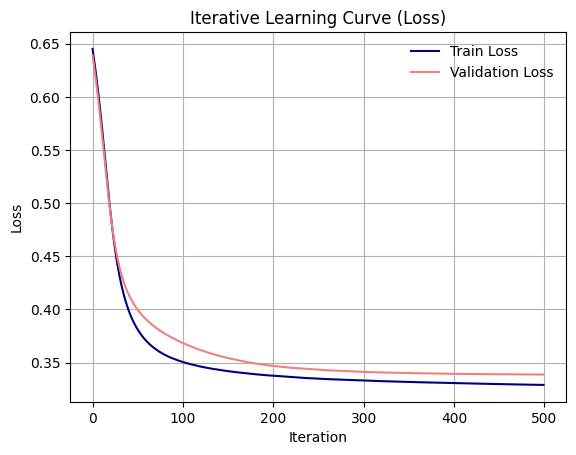

In [15]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

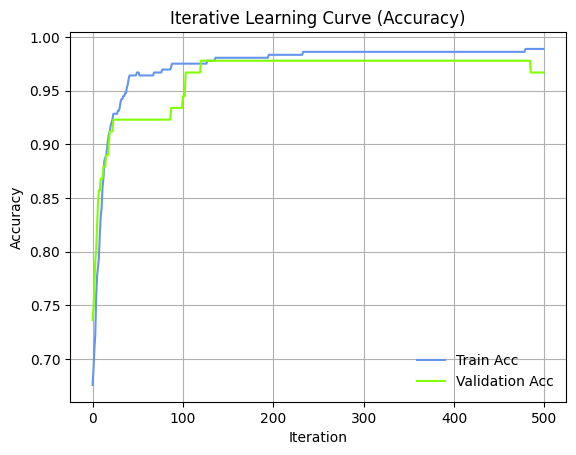

In [16]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

/Users/matthewcaseres/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


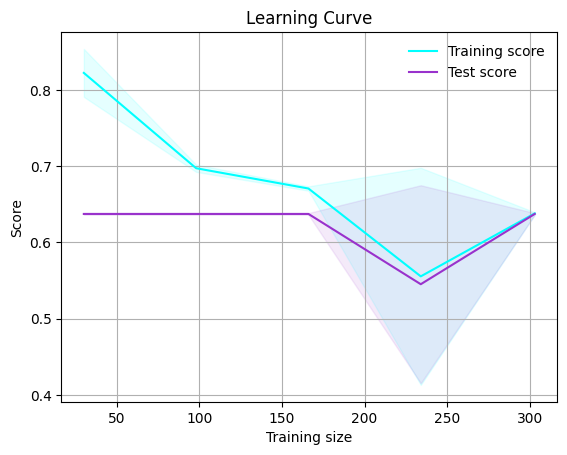

In [17]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn grid search 

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=10; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=10; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=10; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=20; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=20; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=20; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=50; total time=   0.1s
[CV] END net__lr=0.01, net__max_epochs=10, net__module__hidden_layers=1, net__module__hidden_units=50; total time=   0.1s
[CV] END net__lr=0.01, n